In [19]:
import os

import cftime
import numpy as np
import xarray as xr

In [26]:
casename = "c.e22.T62_g37.C1850ECO.1_year"

data_dir = os.path.join(os.path.sep, "glade", "scratch", "mlevy", casename, "run")
ds = xr.open_mfdataset(os.path.join(data_dir, f"{casename}.pop.h.0*.nc"), data_vars="minimal", compat="override", coords="minimal")
ds

<xarray.Dataset>
Dimensions:                          (d2: 2, lat_aux_grid: 105, moc_comp: 3, moc_z: 61, nlat: 116, nlon: 100, time: 12, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
    transport_components             (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions                (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
  * time                             (time) object 0001-02-01 00:00:00 ... 00...
  * z_t                              (z_t) float32 500.0 1500.0 ... 537500.0
  * z_t_150m                         (z_t_150m) float32 500.0 1500.0 ... 14500.0
  * z_w                              (z_w) float32 0.0 1000.0 ... 525000.94
  * z_w_top                          (z_w_top) float32 0.0 1000.0 ... 525000.94
  * z_w_bot                          (z_w_bot) float32 1000.0 ... 549999.06
  * lat_aux_grid                     (lat_aux_grid) float32 -80.26017 ... 90.0
  * moc_z                            (moc_z) float32 0.0 1000.0 ... 549999.06
    ULONG                            (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    ULAT                             (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLONG                            (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLAT                             (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    time_bound                       (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    moc_components                   (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    dz                               (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                              (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    KMU                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    REGION_MASK                      (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    UAREA                            (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TAREA                            (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    HU                               (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    HT                               (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    DXU                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    DYU                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    DXT                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    DYT                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    HTN                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    HTE                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    HUS                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    HUW                              (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    ANGLE                            (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    ANGLET                           (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    days_in_norm_year                timedelta64[ns] ...
    grav                             float64 ...
    omega                            float64 ...
  

In [14]:
def time_set_mid(ds, time_name="time", deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with midpoints of
    ds[time_name].attrs['bounds'], if bounds attribute exists.
    Except for time_name, the returned Dataset is a copy of ds2.
    The copy is deep or not depending on the argument deep.
    """

    ds_out = ds.copy(deep=deep)

    if "bounds" not in ds[time_name].attrs:
        return ds_out

    tb_name = ds[time_name].attrs["bounds"]
    tb = ds[tb_name]
    bounds_dim = next(dim for dim in tb.dims if dim != time_name)

    # Use da = da.copy(data=...), in order to preserve attributes and encoding.

    # If tb is an array of datetime objects then encode time before averaging.
    # Do this because computing the mean on datetime objects with xarray fails
    # if the time span is 293 or more years.
    #     https://github.com/klindsay28/CESM2_coup_carb_cycle_JAMES/issues/7
    if tb.dtype == np.dtype("O"):
        units = "days since 0001-01-01"
        calendar = "noleap"
        tb_vals = cftime.date2num(ds[tb_name].values, units=units, calendar=calendar)
        tb_mid_decode = cftime.num2date(
            tb_vals.mean(axis=1), units=units, calendar=calendar
        )
        ds_out[time_name] = ds[time_name].copy(data=tb_mid_decode)
    else:
        ds_out[time_name] = ds[time_name].copy(data=tb.mean(bounds_dim))

    return ds_out

In [27]:
dso = time_set_mid(ds[["time_bound", "TAREA", "TEMP", "FG_CO2"]].isel(z_t=0).drop(["z_t", "ULAT", "ULONG"]).rename({"TEMP" : "SST"})).drop("time_bound")
dso

<xarray.Dataset>
Dimensions:  (nlat: 116, nlon: 100, time: 12)
Coordinates:
  * time     (time) object 0001-01-17 00:57:36 ... 0001-12-16 12:00:00
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA    (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    SST      (time, nlat, nlon) float32 dask.array<chunksize=(1, 116, 100), meta=np.ndarray>
    FG_CO2   (time, nlat, nlon) float32 dask.array<chunksize=(1, 116, 100), meta=np.ndarray>
Attributes:
    title:             c.e22.T62_g37.C1850ECO.1_year
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-10-30 at 14:04:49.4
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [28]:
dso.nbytes / 1024**2

1.327606201171875

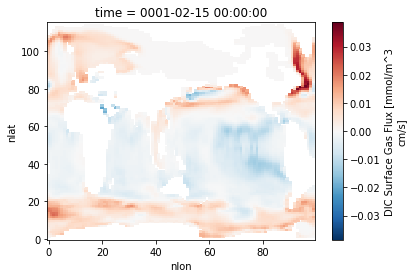

In [23]:
dso.isel(time=1)["FG_CO2"].plot()

In [29]:
dso.to_netcdf("SST_and_CO2FLUX.nc")